![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FDev%2Fnew&file=Document+Q%26A+with+Gemini+Pro+Vision.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Dev/new/Document%20Q%26A%20with%20Gemini%20Pro%20Vision.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FDev%2Fnew%2FDocument%2520Q%2526A%2520with%2520Gemini%2520Pro%2520Vision.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Dev/new/Document%20Q%26A%20with%20Gemini%20Pro%20Vision.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Dev/new/Document%20Q%26A%20with%20Gemini%20Pro%20Vision.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Document Q&A With Gemini Pro Vision

Use Gemini to ask quesiton of document.  

In this case the document is a pdf that contains a long, complex table of drugs included in a plans formulary.  The use case is a plan member asking if a particular drugs is covered by the plan.  This means finding the drug in the formulary, or verifying it is not in the formulary.

Steps:
- Setup:
    - Load PDF in Python
    - Split in to pages
    - Get embedding for each page
    - Store in BigQuery: document path, page number, image, embedding
    - Create Vector Index in BigQuery
- Use:
    - Input Question
    - Use Gemini to extract name for question
    - Get embedding for name
    - Search index for 2 neighbors
    - Retrieve images for pages (the nbeighbors)
    - Use Gemini to see if name is covered in pages
    - Return response
    
Services Used:
- [BigQuery](https://cloud.google.com/bigquery/docs/introduction)
    - [BigQuery Vector Search](https://cloud.google.com/bigquery/docs/vector-search-intro)
- [Vertex AI Gemini Pro and Gemini Pro Vision](https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/overview)
- Python for setup or workflow

Sources:
- The Health Plans Formulary: https://www.healthpartners.com/hp/pharmacy/druglist/preferredrx/
- This is the file: https://healthpartners.adaptiverx.com/web/pdf?key=8F02B26A288102C27BAC82D14C006C6FC54D480F80409B68A4635625D939DFB6



---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [11]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.42.1'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('PIL', 'Pillow'), 
    ('PyPDF2', 'PyPDF2'),
    ('pdf2image', 'pdf2image'), 
]

#!conda install -c conda-forge poppler -y -q
        
import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

In [12]:
importlib.metadata.version('google.cloud.aiplatform') < '1.42.1'

False

### API Enablement

In [13]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [14]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [15]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [16]:
REGION = 'us-central1'
EXPERIMENT = 'plan-formulary'
SERIES = 'applied-genai'

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE_PREFIX = EXPERIMENT
BQ_REGION = REGION[0:2]

# location for the source documents (PDF): can be http:// or gs://, a list of one or more document links
source_documents = ['https://healthpartners.adaptiverx.com/web/pdf?key=8F02B26A288102C27BAC82D14C006C6FC54D480F80409B68A4635625D939DFB6']

Packages

In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import requests
import io
import base64

import PyPDF2
import pdf2image
import IPython
import PIL, PIL.Image

from google.cloud import bigquery
from google.cloud import storage

import vertexai
import vertexai.vision_models
import vertexai.generative_models

Clients

In [21]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)

---
## Process Document

### Get Location of Files

In [22]:
document_locations = []
for source_document in source_documents:
    if source_document.startswith('http'):
        document_locations.append('URL')
        print(f'Use requests to get online document: {source_document}')
    elif source_document.startswith('gs'):
        document_locations.append('GCS')
        print(f'Use GCS to get document in GCS: {source_document}')
    else:
        document_locations.append('UNKNOWN')
        print(f'The source_document variable points to a document in an unknown location type (not gs:// or http://): {source_document}')

Use requests to get online document: https://healthpartners.adaptiverx.com/web/pdf?key=8F02B26A288102C27BAC82D14C006C6FC54D480F80409B68A4635625D939DFB6


### Import the PDF to memory as bytes:

In [23]:
imported_documents = []
for s, source_document in enumerate(source_documents):
    if document_locations[s] == 'URL':
        imported_documents.append(requests.get(source_document).content)
    elif document_locations[s] == 'GCS':
        bucket = gcs.bucket(source_document.split('/')[2])
        blob = bucket.blob(source_document.split(f'gs://{bucket.name}/')[1])
        imported_documents.append(blob.download_as_bytes())
    elif document_locations[s] == 'UNKNOWN':
        imported_documents.append(None)

In [24]:
type(imported_documents[0])

bytes

### Convert from bytes to PDF:

In [25]:
converted_documents = []
for imported_document in imported_documents:
    if imported_document:
        converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
    else:
        converted_documents.append(None)

In [26]:
type(converted_documents[0])

PyPDF2._reader.PdfReader

### Review number of pages per PDF:

In [27]:
for f, file in enumerate(converted_documents):
    if file:
        print(f"{source_documents[f]} has {len(file.pages)} pages")

https://healthpartners.adaptiverx.com/web/pdf?key=8F02B26A288102C27BAC82D14C006C6FC54D480F80409B68A4635625D939DFB6 has 185 pages


### Split PDF(s) into list of individual pages for each file:

In [28]:
raw_files_pages = []
for converted_document in converted_documents:
    if converted_document:
        pages = []
        for page in converted_document.pages:
            writer = PyPDF2.PdfWriter()
            writer.add_page(page)
            with io.BytesIO() as bytes_stream:
                image = pdf2image.convert_from_bytes(writer.write(bytes_stream)[1].getbuffer().tobytes())
                pages.append(image[0])
        raw_files_pages.append(pages)
    else:
        raw_files_pages.append(None)

In [29]:
type(raw_files_pages[0][0])

PIL.PpmImagePlugin.PpmImageFile

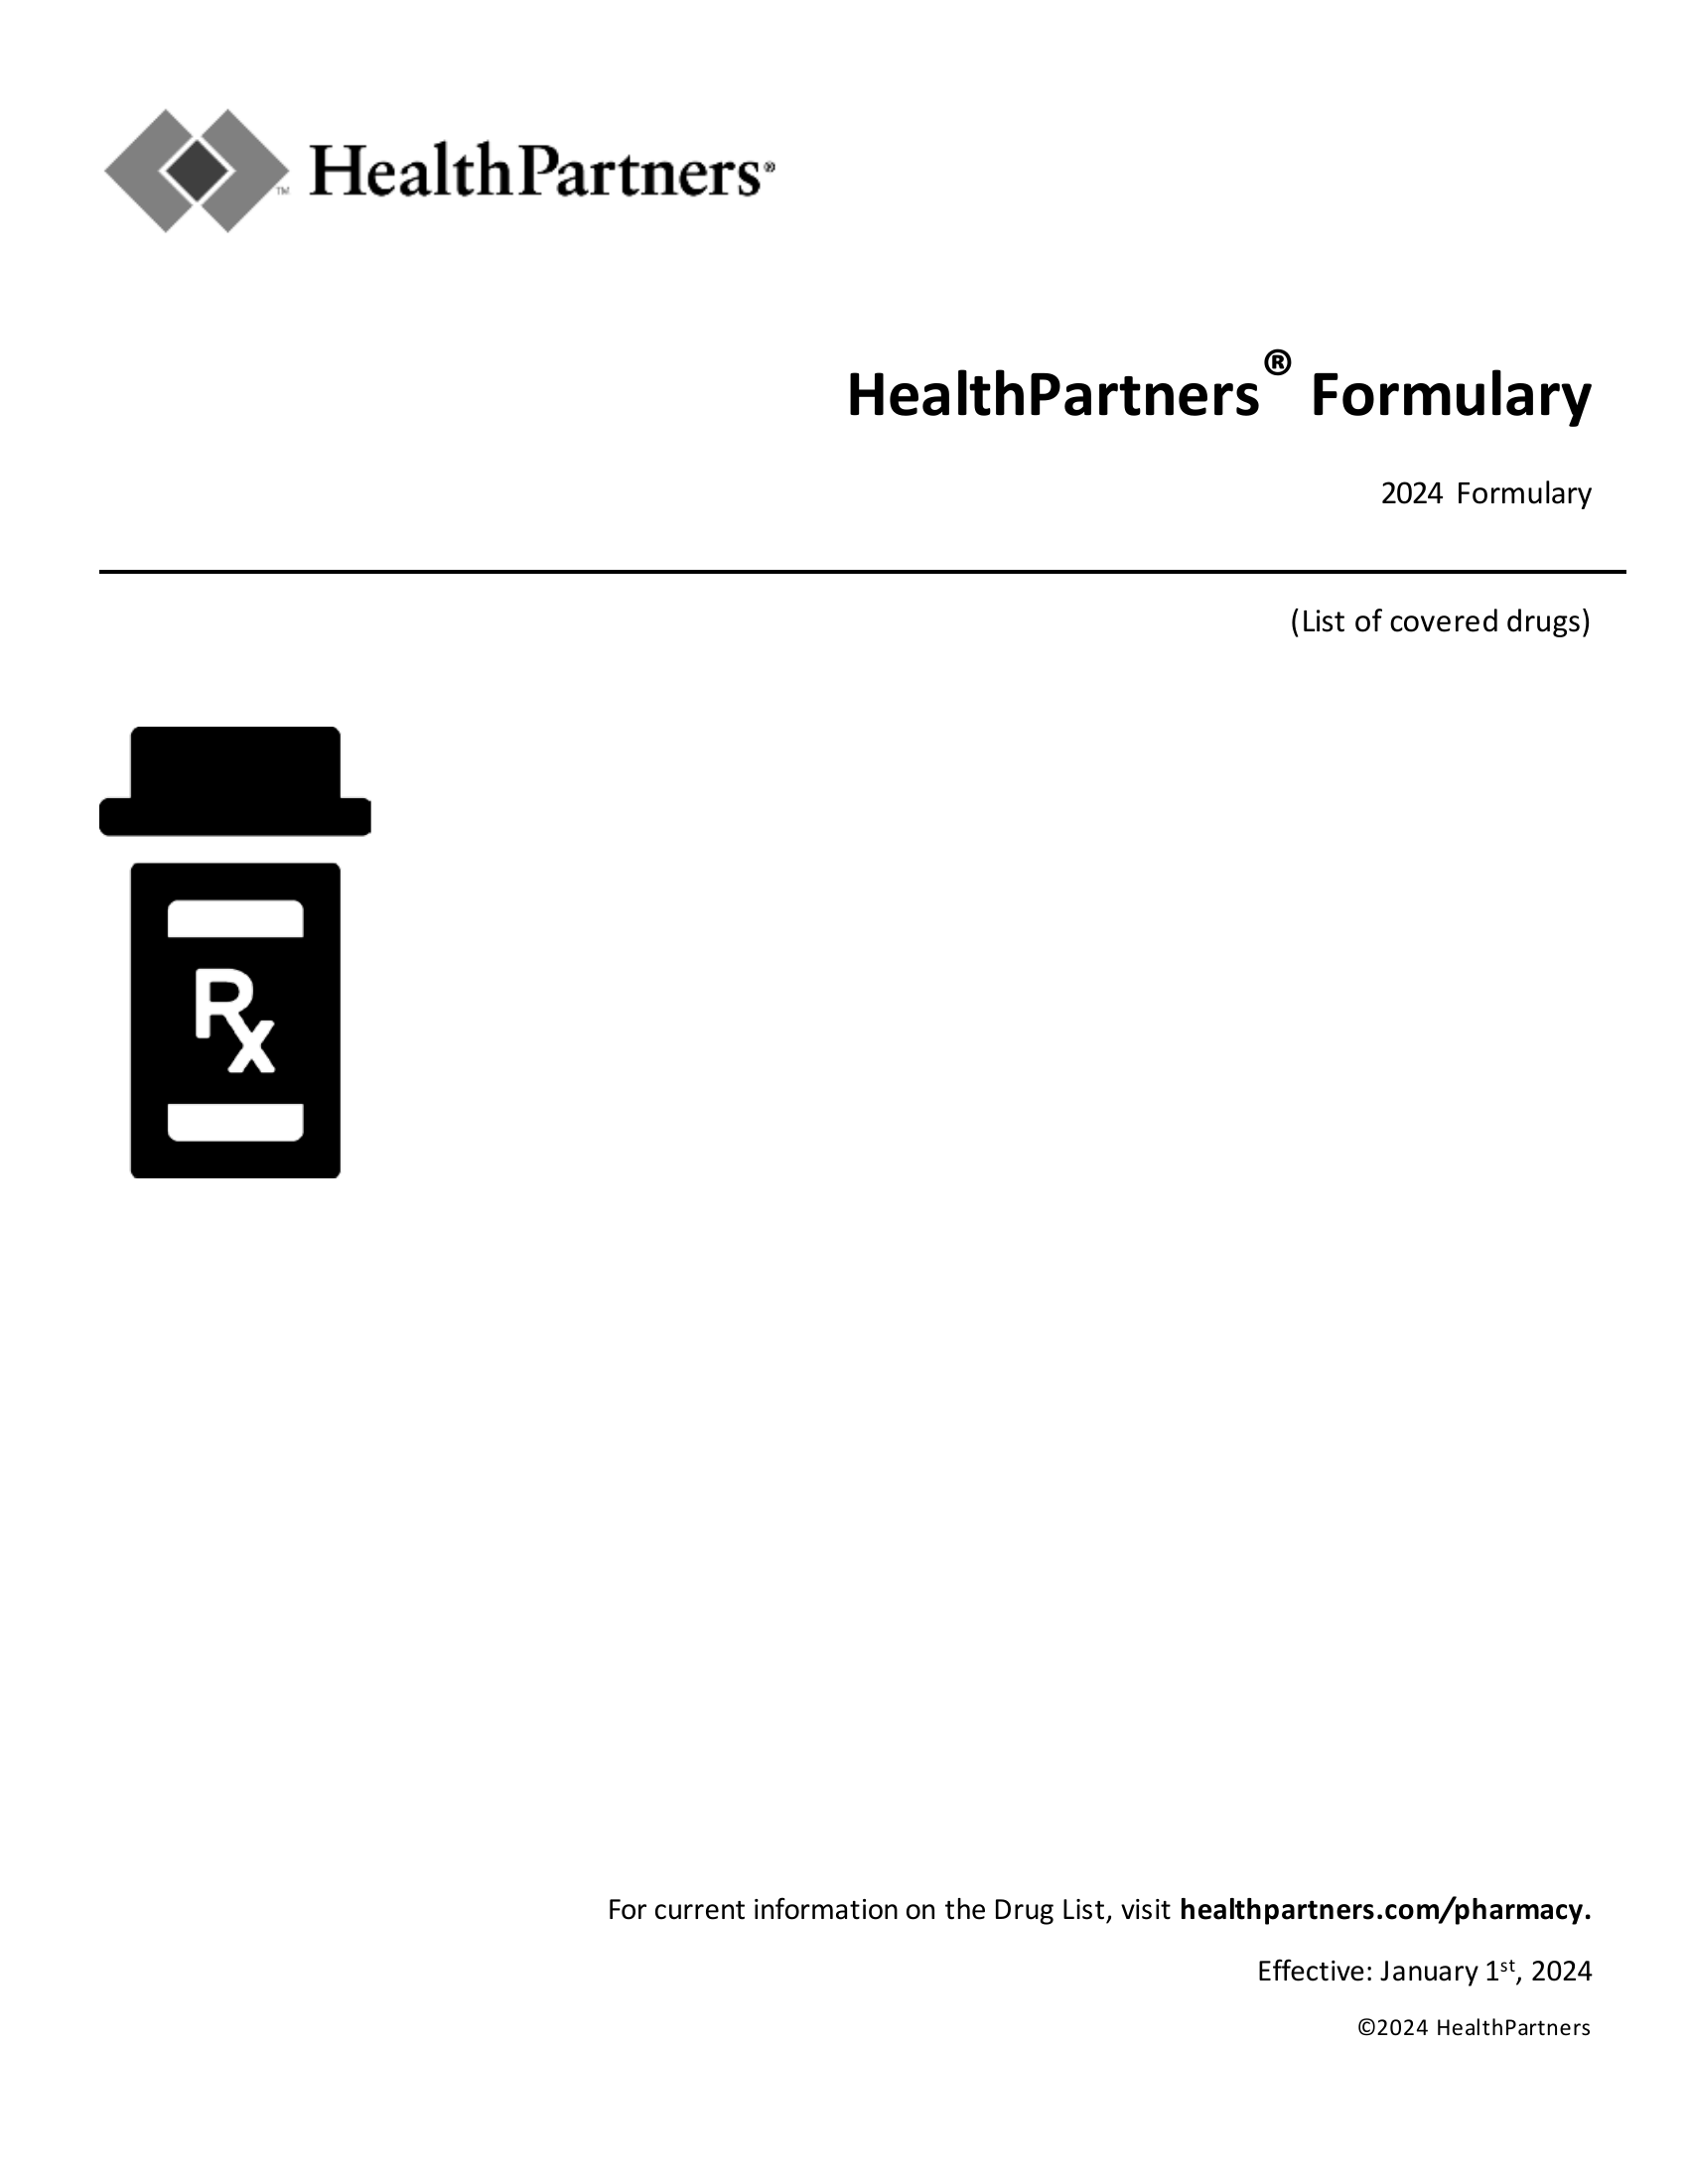

In [30]:
raw_files_pages[0][0]

### Convert images to PNG format As bytes:

In [31]:
bytes_files_pages = []
for file in raw_files_pages:
    holder = []
    for page in file:
        stream = io.BytesIO()
        page.save(stream, format = 'PNG')
        holder.append(stream.getvalue())
    bytes_files_pages.append(holder)

In [32]:
type(bytes_files_pages[0][0])

bytes

---
## Vertex LLM Setup


### Pick An Example Page From Documents

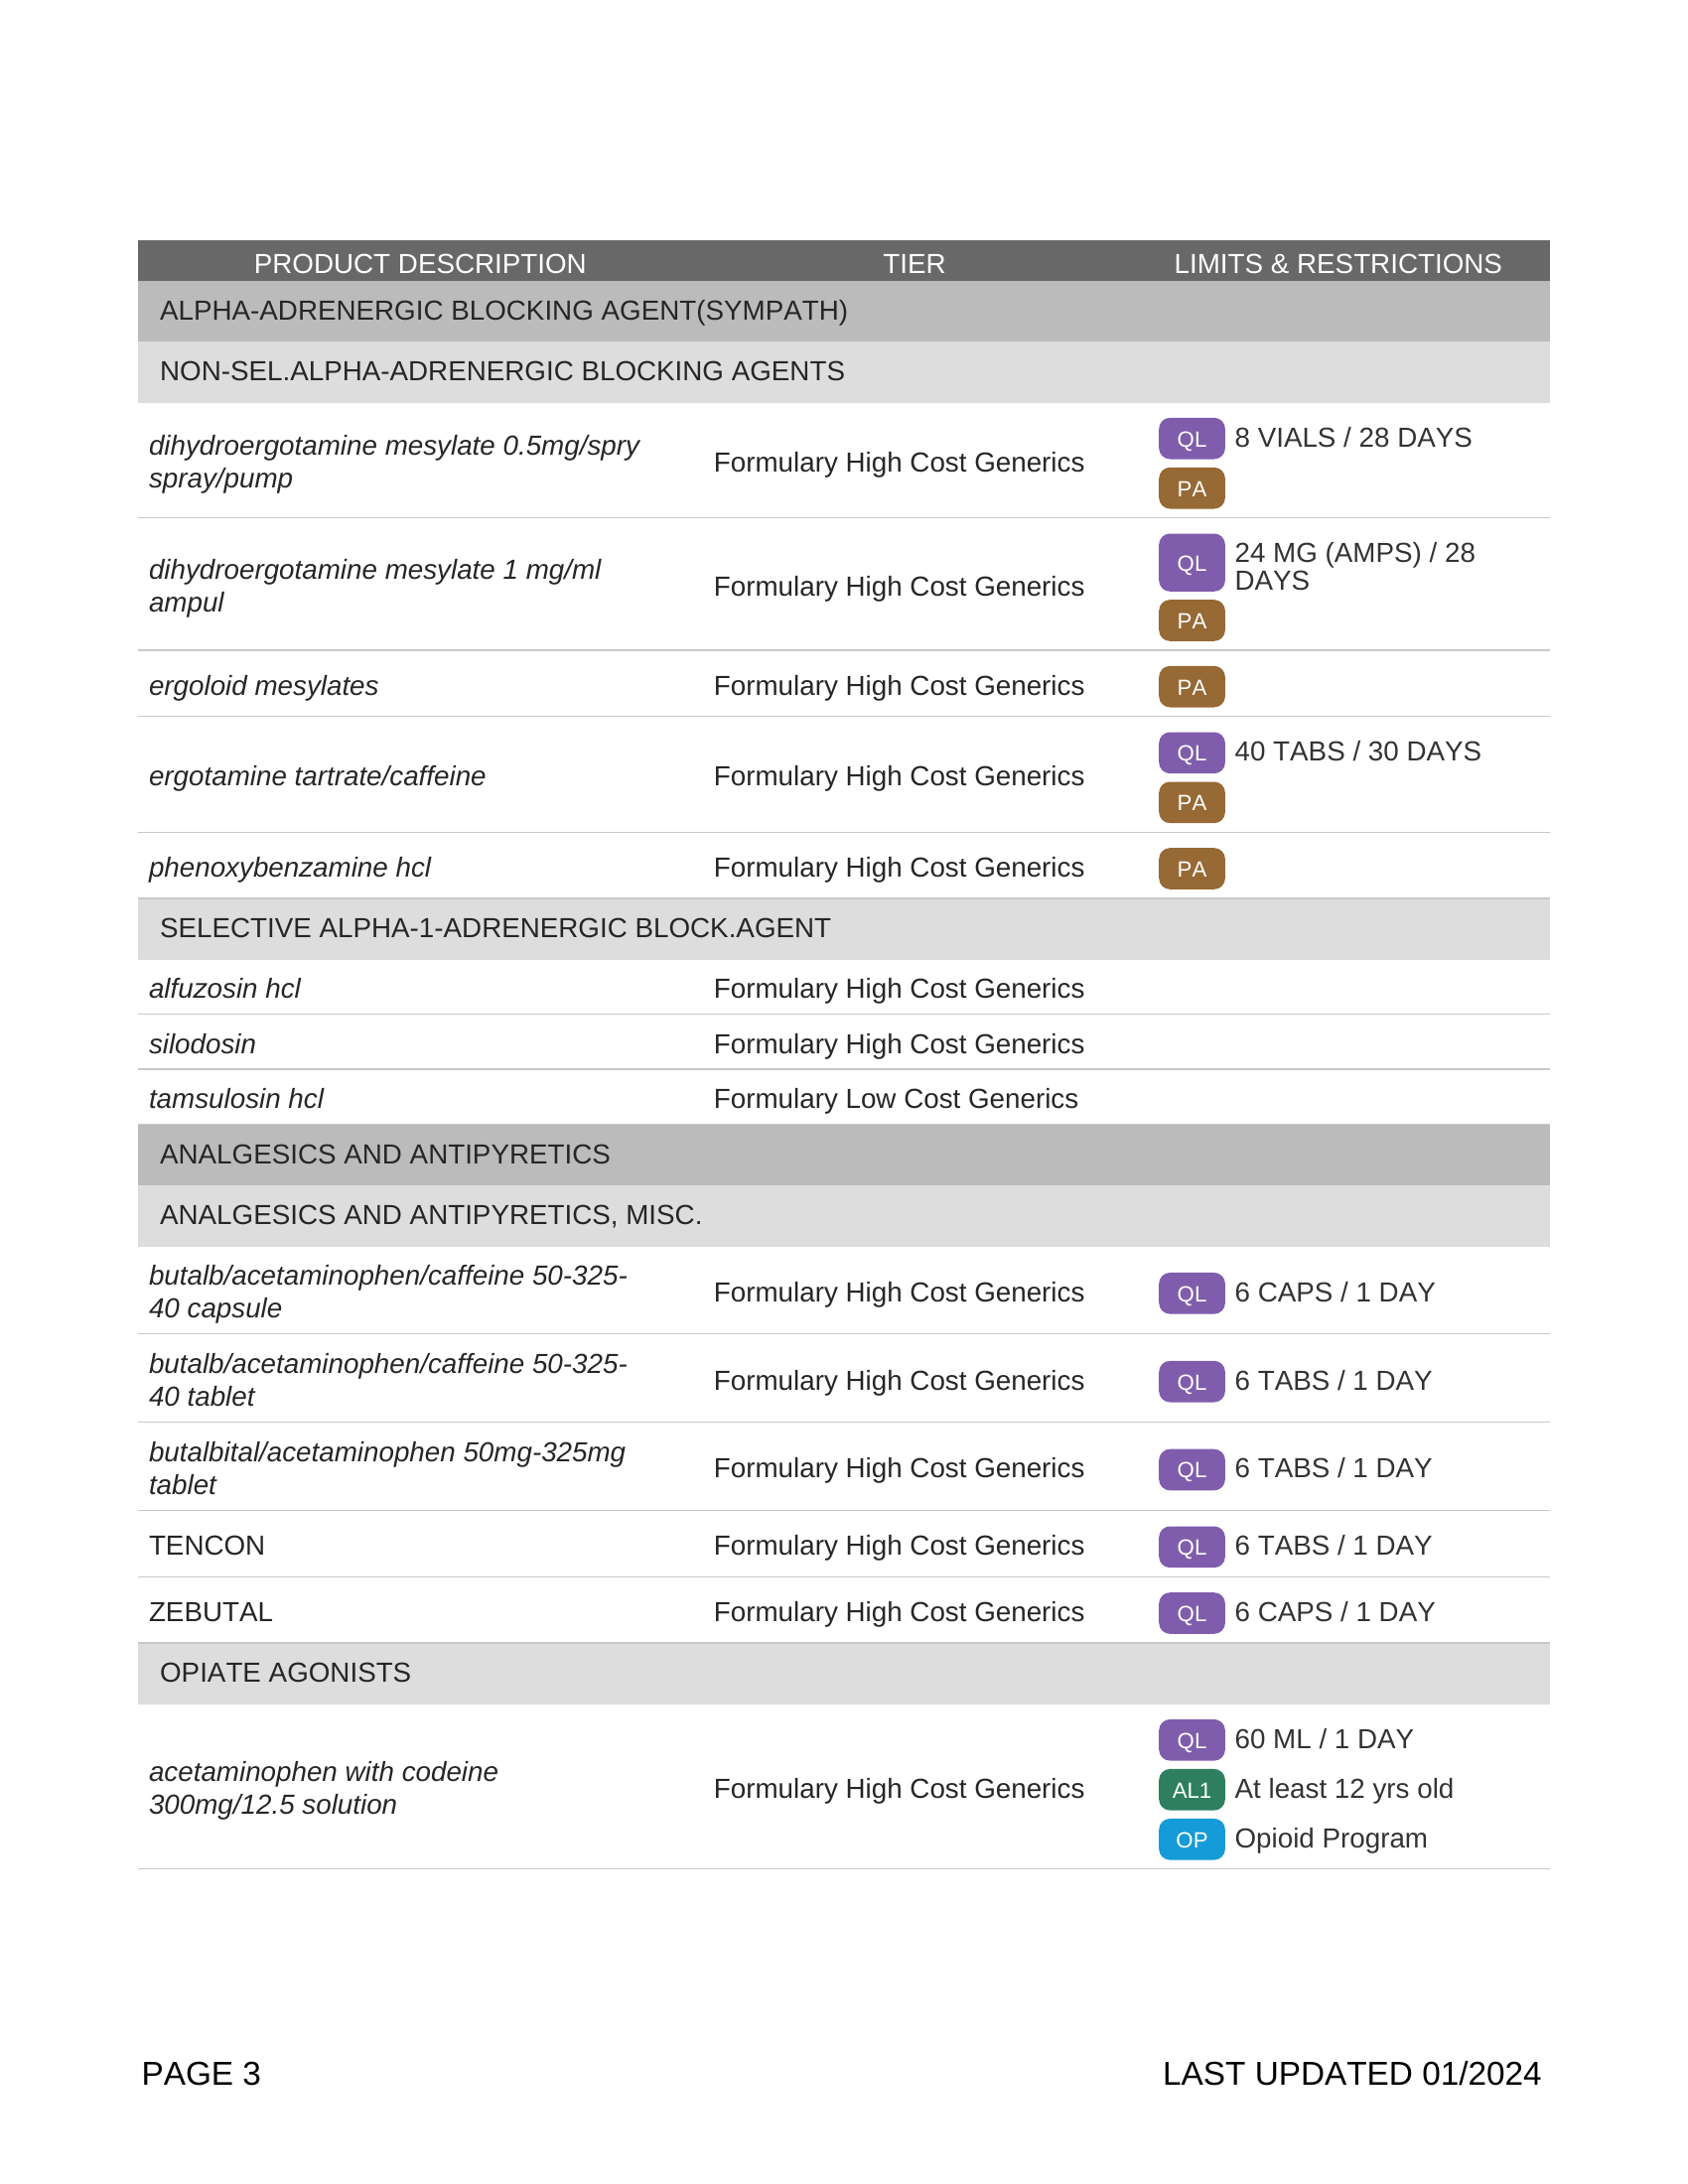

In [33]:
example_question = 'Is tencon described?'
example_page_gemini = vertexai.generative_models.Image.from_bytes(data = bytes_files_pages[0][6])
example_page_image = vertexai.vision_models.Image(image_bytes = bytes_files_pages[0][6])
example_page_image.show()

### Setup Models

In [34]:
# create links to models
gemini_text = vertexai.generative_models.GenerativeModel("gemini-1.0-pro")
gemini_multimodal = vertexai.generative_models.GenerativeModel("gemini-1.0-pro-vision")
multimodal_embedding = vertexai.vision_models.MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

### Multimodal Embeddings: Text Only

In [35]:
text_embed = multimodal_embedding.get_embeddings(contextual_text = example_question)

In [36]:
type(text_embed)

vertexai.vision_models.MultiModalEmbeddingResponse

In [37]:
len(text_embed.text_embedding)

1408

In [38]:
text_embed.text_embedding[0:5]

[0.01803842, -0.0656989291, 0.0306459498, 0.0355640762, -0.00500265695]

### Multimodal Embeddings: Image Only

In [39]:
image_embed = multimodal_embedding.get_embeddings(image = example_page_image)

In [40]:
type(image_embed)

vertexai.vision_models.MultiModalEmbeddingResponse

In [41]:
len(image_embed.image_embedding)

1408

In [42]:
image_embed.image_embedding[0:5]

[-0.0163568072, -0.0498247221, 0.0164615139, -0.027808249, 0.0119175743]

### Multimodal Embeddings: Image And Text

In [43]:
multi_embed = multimodal_embedding.get_embeddings(contextual_text = example_question, image = example_page_image)

In [44]:
type(multi_embed)

vertexai.vision_models.MultiModalEmbeddingResponse

In [45]:
len(multi_embed.image_embedding)

1408

In [46]:
len(multi_embed.text_embedding)

1408

### Generate With Gemini Pro

Note: The model does not have context for grounding, like the image:

In [47]:
for response in gemini_text.generate_content(example_question, stream = True):
    print(response.text)

Tencon is not described in the provided context.


In [75]:
response = gemini_text.generate_content(example_question)
response

candidates {
  content {
    role: "model"
    parts {
      text: "The provided context does not mention tencon. So I cannot answer the question."
    }
  }
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
  }
}
usage_metadata {
  prompt_token_count: 5
  candidates_token_count: 16
  total_token_count: 21
}

In [76]:
response.text

'The provided context does not mention tencon. So I cannot answer the question.'

### Generate With Gemini Pro Vision - Multimodal

Here the page image is included as context for grounding the answer to the question:

In [68]:
safety_config = {
    vertexai.generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: vertexai.generative_models.HarmBlockThreshold.BLOCK_NONE
}

In [73]:
response = gemini_multimodal.generate_content([example_page_gemini, example_question], safety_settings = safety_config)

In [74]:
response.text

' Yes'

In [72]:
for response in gemini_multimodal.generate_content([example_page_gemini, example_question], safety_settings = safety_config, stream = True):
    print(response.text)

 Yes


---
## Store Embeddings In BigQuery

https://cloud.google.com/bigquery/docs/vector-search-intro

### Create/Retrieve BigQuery Dataset

In [124]:
ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
ds.location = BQ_REGION
ds = bq.create_dataset(dataset = ds, exists_ok = True)   

In [125]:
ds

Dataset(DatasetReference('statmike-mlops-349915', 'applied_genai'))

### Prepare Embeddings For BigQuery

In [192]:
files_pages_save = []
for f, file in enumerate(bytes_files_pages):
    for p, page in enumerate(file):
        embed = multimodal_embedding.get_embeddings(
            image = vertexai.vision_models.Image(image_bytes = page)
        )
        files_pages_save.append(
            dict(
                file_id = f,
                file_path = source_documents[f],
                page_id = p,
                page_image = base64.b64encode(page).decode('utf-8'), #base64.decodebytes(page),
                embedding = embed.image_embedding
            )
        )

In [193]:
len(files_pages_save)

185

In [194]:
files_pages_save[0].keys()

dict_keys(['file_id', 'file_path', 'page_id', 'page_image', 'embedding'])

In [195]:
files_pages_save[0]['page_image'][0:100]

'iVBORw0KGgoAAAANSUhEUgAABqQAAAiYCAIAAAA+NVHkAAEAAElEQVR4nOzdZ3Tj6XnfffTeCBAgCTawznAKp+9snZ1t0q60q428'

### Load To BigQuery

In [196]:
# make load job configuration
job_config = bigquery.LoadJobConfig(
    source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
    write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE,
    create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED,
    autodetect = True
)    

# save files_pages
load_job = bq.load_table_from_json(
    json_rows = files_pages_save,
    destination = ds.table(BQ_TABLE_PREFIX + '_files_pages'),
    job_config = job_config
)
load_job.result()

LoadJob<project=statmike-mlops-349915, location=US, id=2a64d679-5a59-4b39-bfaf-963774178662>

### Query Embedding

Embed the question and use it for search:

In [210]:
question = 'Is tencon described?'

text_embed = multimodal_embedding.get_embeddings(
    contextual_text = question
)

In [211]:
len(text_embed.text_embedding)

1408

### Vector Search

For under 5000 rows no index is needed, use VECTOR SEARCH with brute force:

In [205]:
query = f'''
SELECT base.*, distance
FROM
    VECTOR_SEARCH(
        TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_files_pages`,
        'embedding',
        (SELECT {text_embed.text_embedding} AS embedding),
        top_k => 2,
        options => '{{"use_brute_force": true}}'
    )
'''
bq_job = bq.query(query = query, job_config = bigquery.QueryJobConfig(use_query_cache = False))
bq_job.result()
(bq_job.ended - bq_job.started).total_seconds()

2.777

In [206]:
result = bq_job.to_dataframe()
result

,page_image,embedding,page_id,file_path,file_id,distance
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[-0.00888863578, -0.037706323, 0.0550599322, -...",98,https://healthpartners.adaptiverx.com/web/pdf?...,0,1.394643
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[-0.00193596107, -0.0446418896, 0.0234857537, ...",26,https://healthpartners.adaptiverx.com/web/pdf?...,0,1.394895


## Load Pages From Response

In [207]:
context = []
for row in range(result.shape[0]):
    context.append(
        vertexai.preview.generative_models.Image.from_bytes(
            #data = base64.b64decode(result['page_image'].iloc[row])
            data = result['page_image'].iloc[row]
        )
    )    

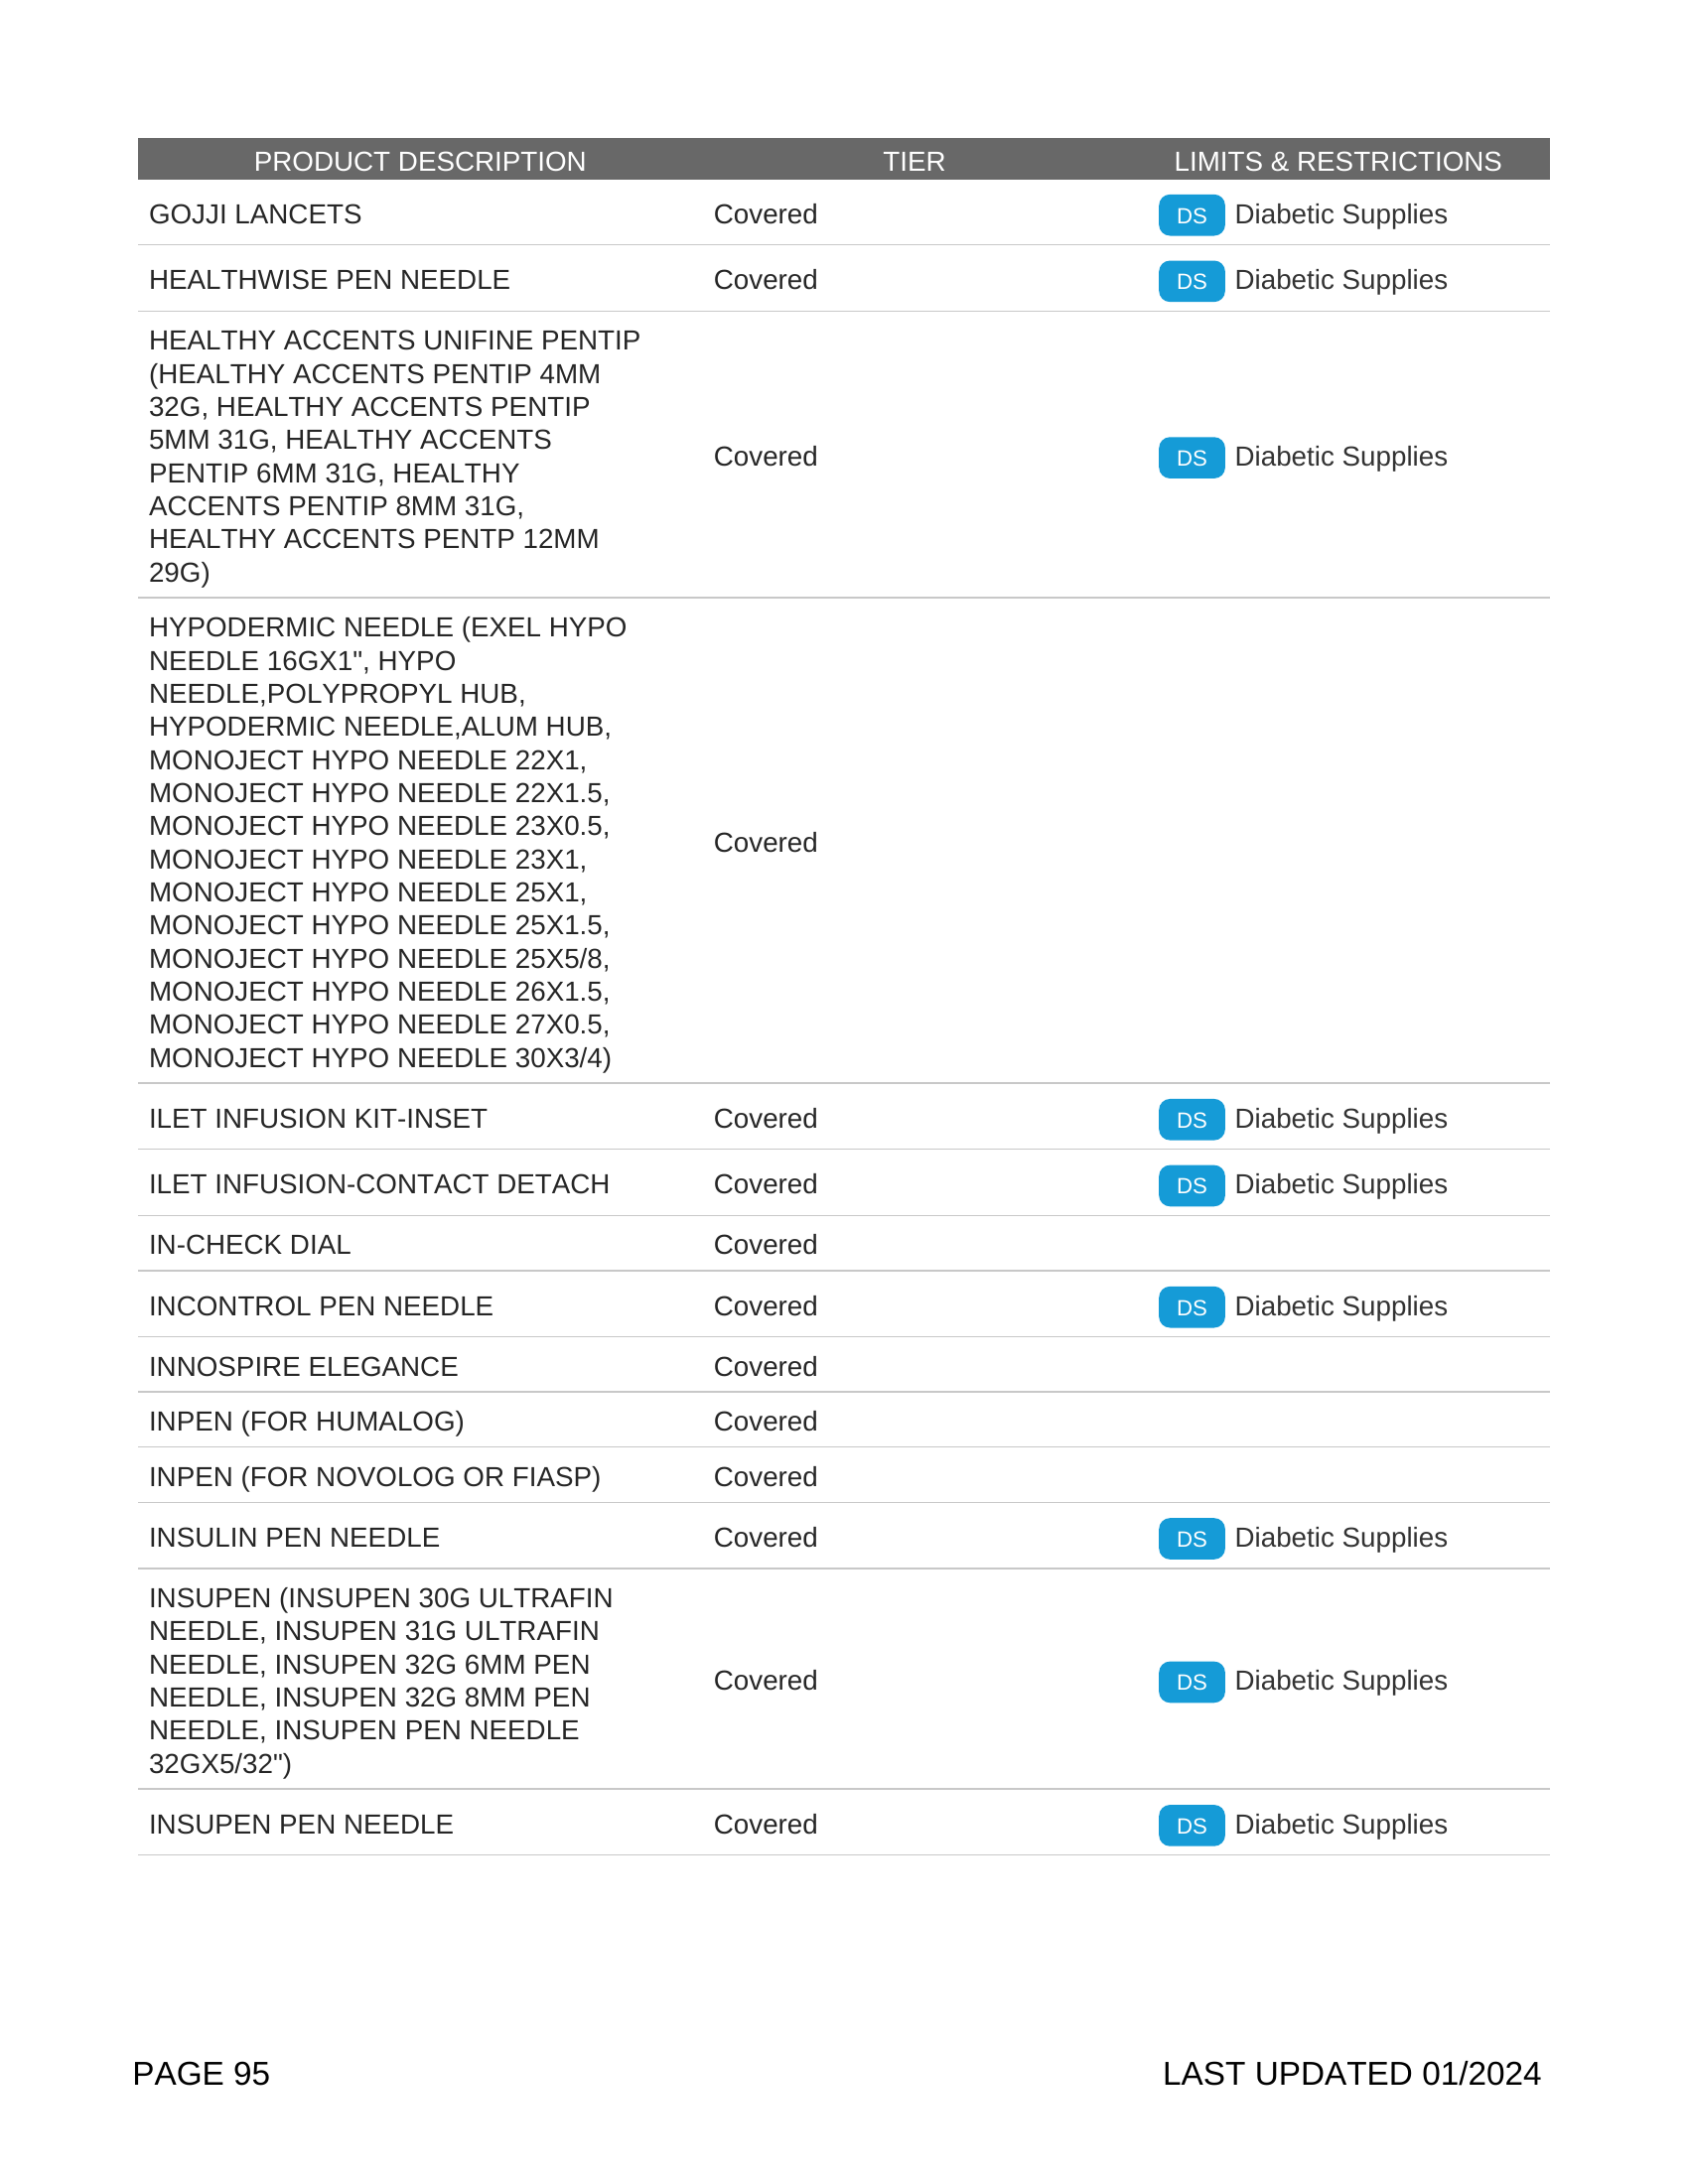

In [208]:
context[0]

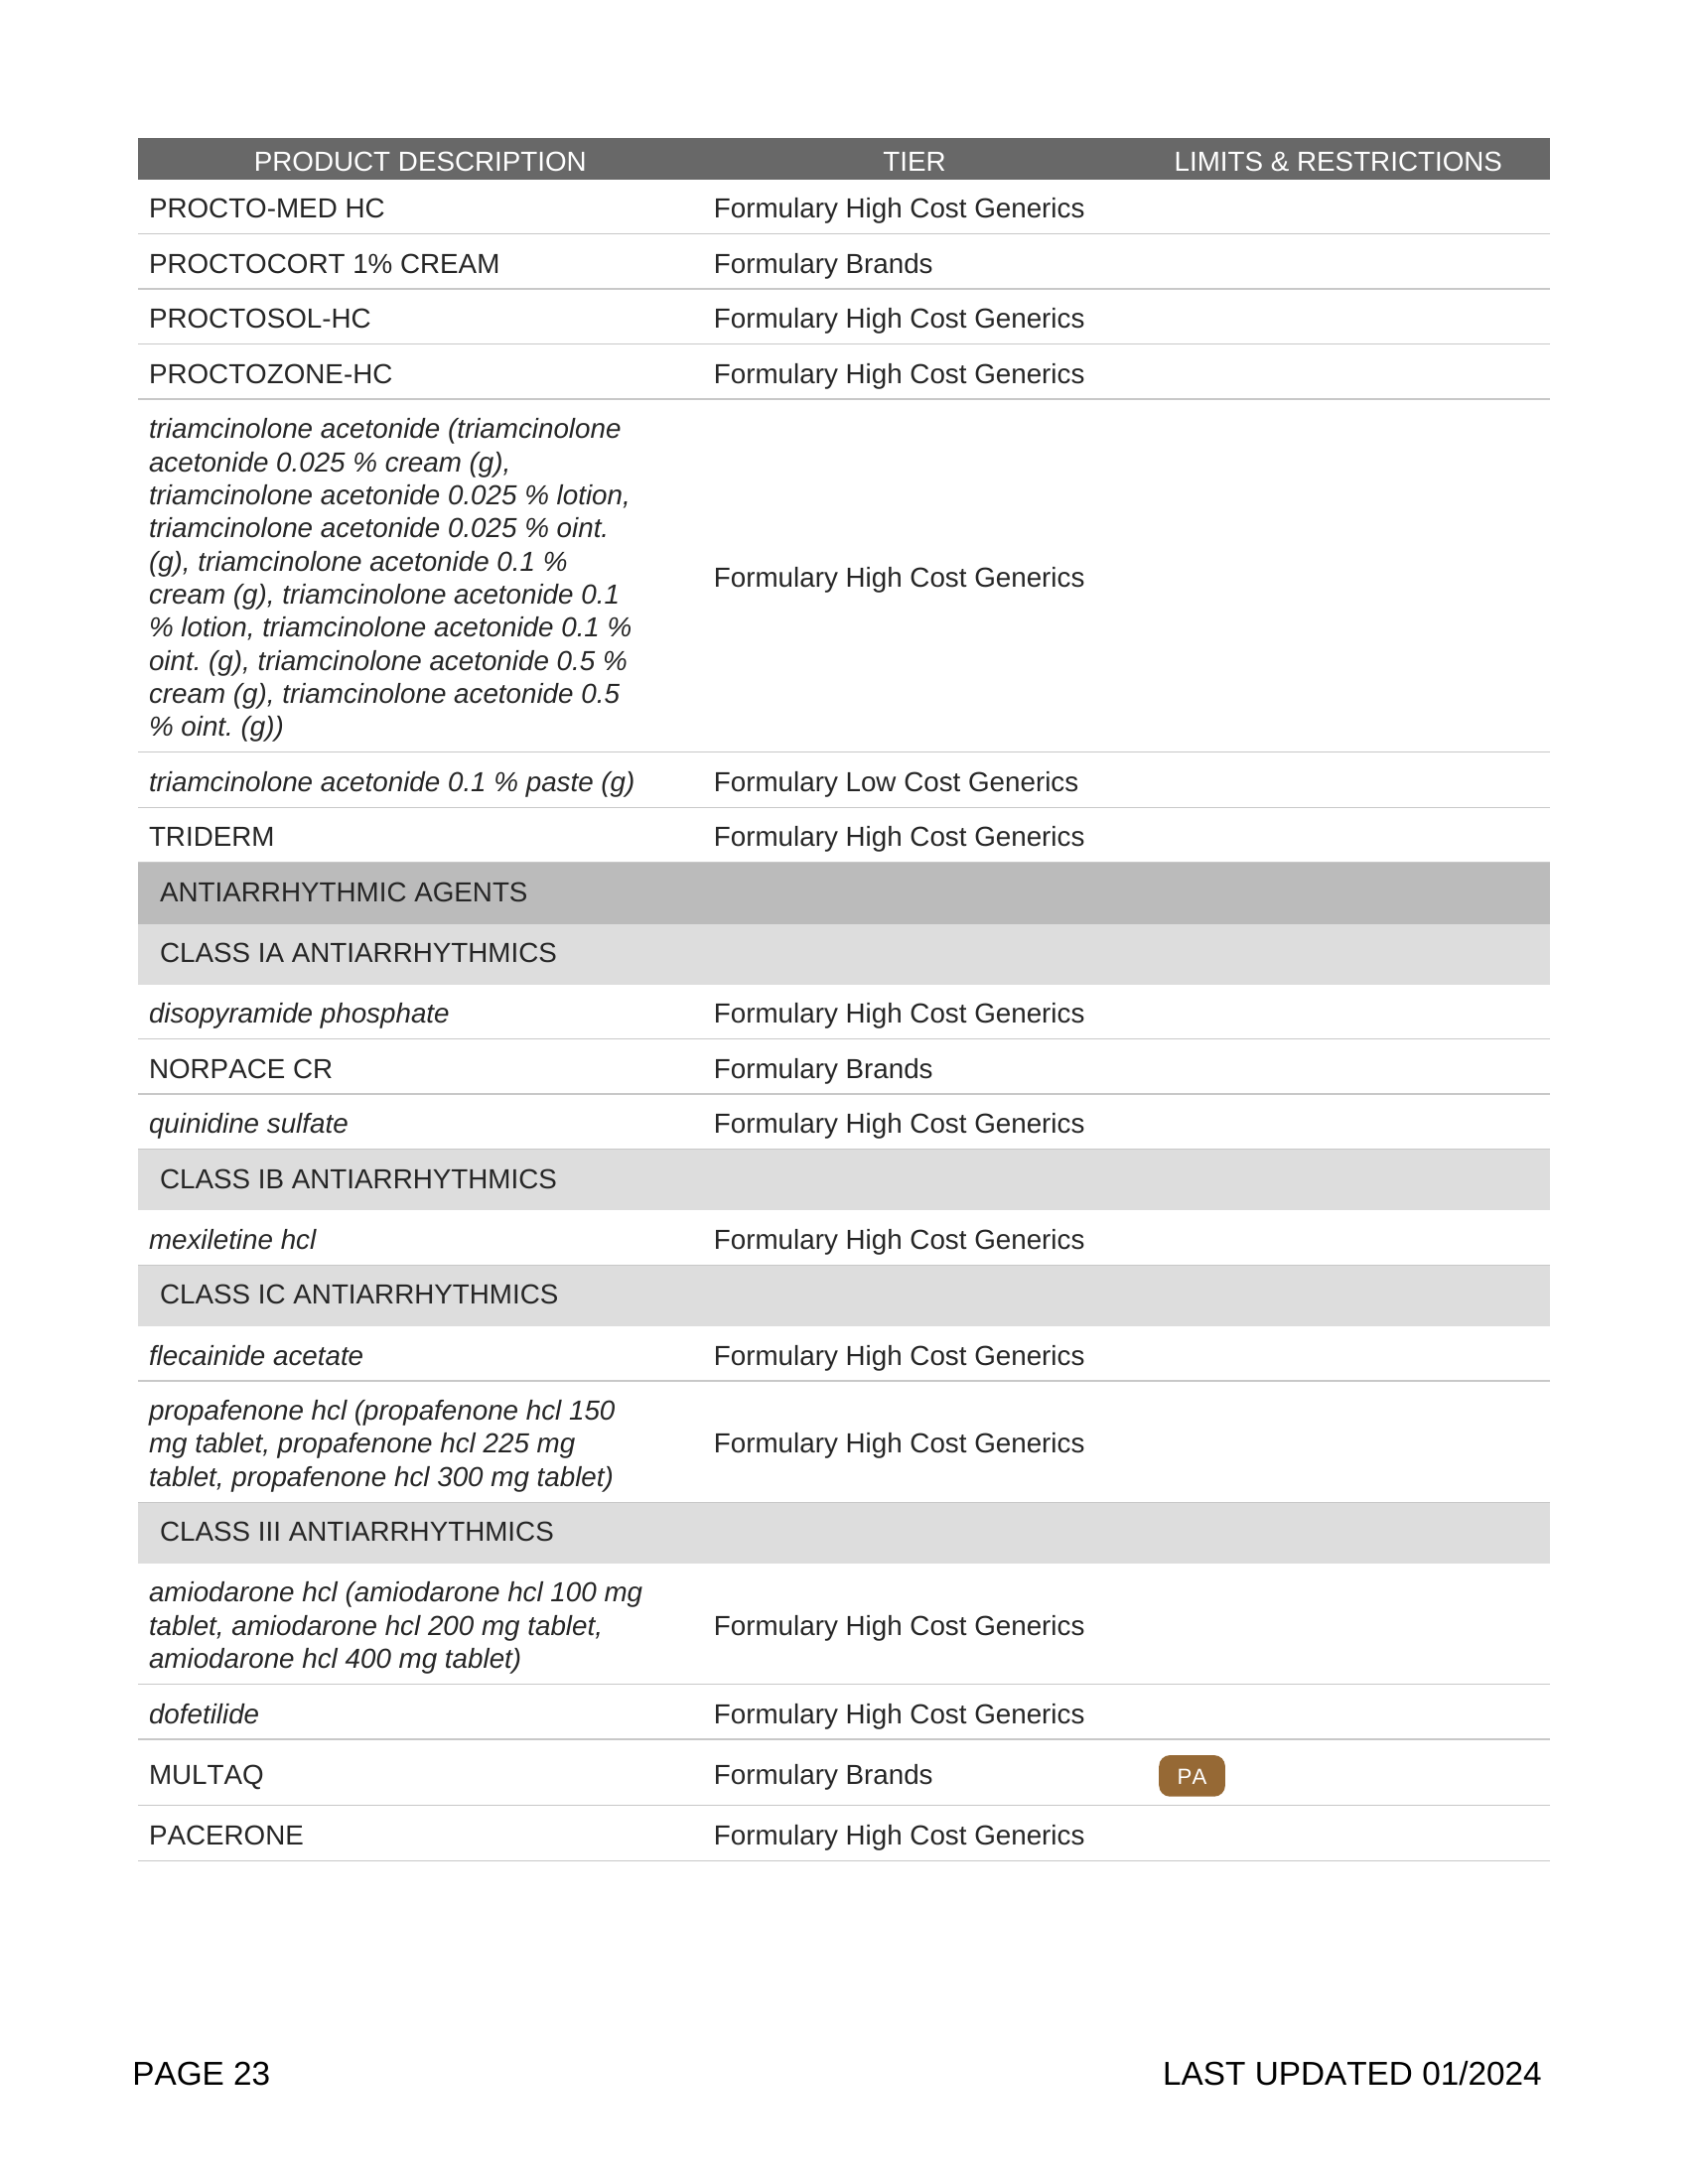

In [209]:
context[1]

### Generate With Gemini Pro Vision - Multimodal

Here the page image is included as context for grounding the answer to the question:

In [215]:
for response in gemini_multimodal.generate_content(context + [question], stream = True):
    print(response.text)

 Yes


In [225]:
response = gemini_multimodal.generate_content(context + [question])

In [226]:
response.text

' No, tencon is not described.'

---
# NOTES

As is, this approach is not great at returning the associated pages for the relatively short prompts including drug names.  This can because drug names are relatively obscure and not common english language words that also do not sound like or associate with words.

Thoughts for progression:
- use Vertex AI Search & Conversation to help identify the pages, then proceed with the Gemini prompt as above
- Also chunk and embed the page contents then do the search on text embeddings to retrieve associated chunk.  Then also grab the full page images for pages with related text chunks.